<a href="https://colab.research.google.com/github/fellowship/platform-demos3/blob/master/blob/master/Burn/models/burn_hp_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

In this notebook , we perform various experiments to refine the burn model and hyperparameters. We use the  burn_nosplit_final dataset, and initially train on ResNet34 with 'mixup'. We then train the model for varying dropout rates (ps) and image sizes (sz) while also observing accuracy vs learning rate (lr) curve at each ps, bs and sz . We plot the top losses to understand the incorrectly classified classes and suggest to add more 'none' type images that resemble 1/2/3 classes in the 'none' training set of burn_nosplit_final dataset. We also observe that some training results for burn-tv-cur yield unusual >95% accuracy resulting from data leakage in train/valid set such as duplicates. Finally, we vary the architecture to determine the model with highest accuracy. Note: results may vary on repeated runs so we plan to average the results over several runs.




In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import time
import os
import sys
import importlib.util
from pathlib import Path
from google.colab import drive

import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.models import *


import numpy as np
import matplotlib.pyplot as plt


print("Fastai Version: ",fastai.__version__)

Fastai Version:  1.0.52


In [0]:
# !pip install --upgrade git+https://github.com/fastai/fastai.git    #use new version 1.0.53 

In [4]:
# Top level data directory. 

drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
sys.path.append('/content/gdrive/My Drive')

Mounted at /content/drive


In [5]:
path = Path('/content/drive/My Drive/burn/burn_nosplit_final/')
path.ls()

[PosixPath('/content/drive/My Drive/burn/burn_nosplit_final/1'),
 PosixPath('/content/drive/My Drive/burn/burn_nosplit_final/2'),
 PosixPath('/content/drive/My Drive/burn/burn_nosplit_final/3'),
 PosixPath('/content/drive/My Drive/burn/burn_nosplit_final/none'),
 PosixPath('/content/drive/My Drive/burn/burn_nosplit_final/models'),
 PosixPath('/content/drive/My Drive/burn/burn_nosplit_final/burn_model_TL_imagenet.pth')]

In [0]:
# !ls

## Training and Predictions : ResNet34 with mixup

- Initial traning with default values. 

In [0]:
tfms = get_transforms(flip_vert=True)
np.random.seed(0)
data1 = ImageDataBunch.from_folder(path, valid_pct=0.3, ds_tfms=tfms, size=224).normalize(imagenet_stats) #valid_pct=0.3

In [0]:
data1.show_batch(rows=3, figsize=(6, 6))
print('Classes: ',data1.classes)

In [0]:
learn_1 = cnn_learner(data1, models.resnet34, metrics=accuracy).mixup()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


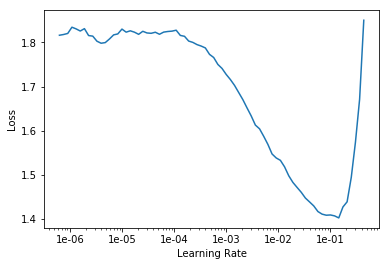

In [10]:
learn_1.lr_find()
learn_1.recorder.plot()

Note: Learning rate lr = slice(1e-3,5e-2) or  lr_max = 0.1 (seem optimal), also confirmed while varying the number of epochs, image sizes, and dropout rates. 

In [11]:
learn_1.fit_one_cycle(5, 1e-2, pct_start=0.5, callbacks=[SaveModelCallback(learn_1, every='improvement', monitor='accuracy', name='best_1')])

epoch,train_loss,valid_loss,accuracy,time
0,1.531702,0.957675,0.549550,00:11
1,1.347738,0.831197,0.675676,00:12
2,1.239256,1.008926,0.630631,00:12
3,1.147225,0.687593,0.720721,00:13
4,1.060764,0.679971,0.747748,00:12


Better model found at epoch 0 with accuracy value: 0.5495495200157166.
Better model found at epoch 1 with accuracy value: 0.6756756901741028.
Better model found at epoch 3 with accuracy value: 0.7207207083702087.
Better model found at epoch 4 with accuracy value: 0.7477477192878723.


In [12]:
accuracy(*learn_1.get_preds())

tensor(0.7477)

In [0]:
# learn_1.save('burn_nosplit_final_default')

In [0]:
learn_1.unfreeze()

In [15]:
learn_1.fit_one_cycle(5, slice(1e-3, 5e-2), pct_start=0.5, callbacks=[SaveModelCallback(learn_1, every='improvement', monitor='accuracy', name='best_1')])

epoch,train_loss,valid_loss,accuracy,time
0,1.046634,4.724405,0.585586,00:12
1,1.053883,483.375366,0.445946,00:12
2,1.202080,14808.934570,0.306306,00:12
3,1.226716,62.974575,0.423423,00:11
4,1.206506,3.383377,0.599099,00:13


Better model found at epoch 0 with accuracy value: 0.5855855941772461.
Better model found at epoch 4 with accuracy value: 0.5990990996360779.


In [16]:
accuracy(*learn_1.get_preds())

tensor(0.5991)

###  Top Losses


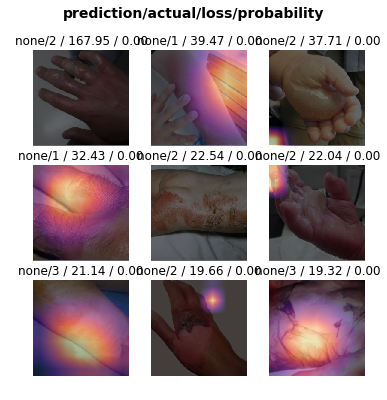

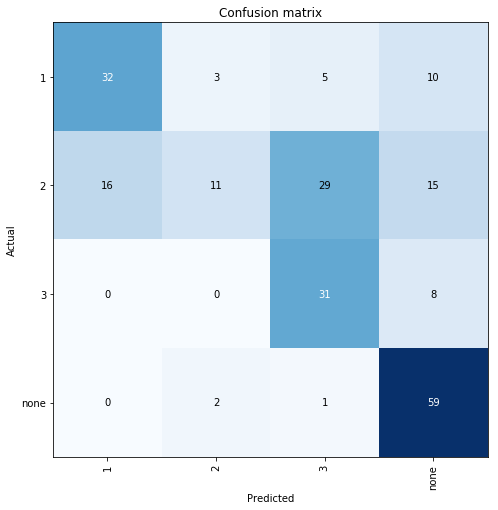

In [17]:
interp = ClassificationInterpretation.from_learner(learn_1)
losses, idxs = interp.top_losses()

interp.plot_top_losses(9, figsize=(6, 6))
interp.plot_confusion_matrix(figsize=(7, 7))

In [0]:
# image file names that were inaccuractely classified
# losses,idxs = interp.top_losses(10)
# for p in data1.valid_ds.x.items[idxs]:
#   print(p)

Note: Most inaccurately classified images are on the off-diagonal of the confusion matrix between 2/1 , 2/3 and (2/none.  Adding more type 2 and more 'none' type curated training dataset is necessary to increase classification accuracy.

### Varying Batch Sizes (bs = 8,16,32,64,128)

Note: if your GPU is running out of memory, set a smaller batch size, e.g. 32 or 16.

- It will also be interesting to change the [lr as we vary bs](https://miguel-data-sc.github.io/2017-11-05-first/) where it's shown optimal lr gets higher as bs increases.


In [0]:
batchsizes = [8,16,32,64,128]
acc_bs = []   #accuracy array

#loop through all entries in the batchsizes array
for bs in batchsizes:
  
    np.random.seed(0)
    data_bs = ImageDataBunch.from_folder(path, valid_pct=0.3, ds_tfms=tfms, size=224, bs=bs).normalize(imagenet_stats)
    learn_bs = cnn_learner(data_bs, models.resnet34, metrics=accuracy).mixup()
    
#     learn.lr_find()
#     learn.recorder.plot()

    print('Batch Size:', bs)
    %time 
    fit_array = learn_bs.fit_one_cycle(5, 1e-3, pct_start=0.5, callbacks=[SaveModelCallback(learn_bs, every='improvement', monitor='accuracy', name='best_1')])

    acc_bs.append( accuracy(*learn_bs.get_preds()) )


learn_bs.save('burn_nosplit_final_bs')

In [20]:
print(batchsizes)
print(acc_bs)

[8, 16, 32, 64, 128]
[tensor(0.6892), tensor(0.7117), tensor(0.7072), tensor(0.7072), tensor(0.7207)]


#### Plot of Varying Batch Size Results

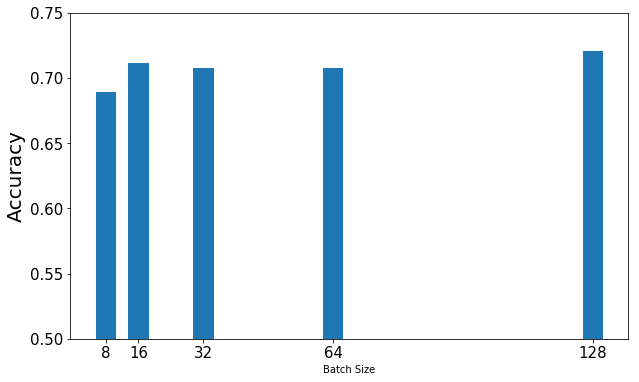

In [21]:
width = 5 # bar width
# Get current size
fig_size = plt.rcParams["figure.figsize"]
# Set new size (0=width,1=height)
fig_size[0] = 10
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size


plt.bar(batchsizes, acc_bs, width, align='center')

plt.tick_params(axis='x', which='major', labelsize=15)
plt.tick_params(axis='y', which='major', labelsize=15)

xrange = np.arange(0,130,32)
plt.xticks(batchsizes)
plt.ylim(.5,.75)

plt.xlabel('Batch Size', size = 10)
plt.ylabel('Accuracy',size = 20)

plt.show()

### Varying Dropout rates (ps = 0.0 to 0.9)  

In [0]:
dropouts = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
acc_ps = []   #accuracy array

#loop through all entries in the dropouts array, bs = 64
for dropout in dropouts:
    learn_ps = cnn_learner(data1, models.resnet34, metrics=accuracy, ps=dropout).mixup()
    
#     learn.lr_find()
#     learn.recorder.plot()

    print('Dropout Rate:',dropout)
    %time 
    fit_array = learn_ps.fit_one_cycle(5,1e-2, pct_start=0.5, callbacks=[SaveModelCallback(learn_ps, every='improvement', monitor='accuracy', name='best_1')])

    acc_ps.append( accuracy(*learn_ps.get_preds()) )

learn_ps.save('burn_resplit_out2_ps')

In [23]:
print(dropouts)
print(acc_ps)

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
[tensor(0.7432), tensor(0.7477), tensor(0.7432), tensor(0.7117), tensor(0.7297), tensor(0.7162), tensor(0.7387), tensor(0.7387), tensor(0.7432), tensor(0.7658)]


#### Plot of Varying Dropout Rate Results

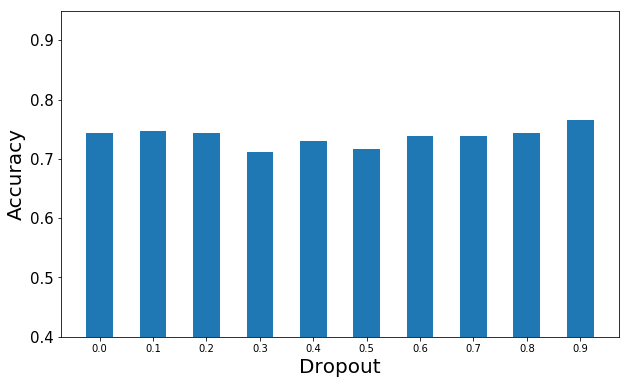

In [24]:
width = 0.05 # bar width
# Get current size
fig_size = plt.rcParams["figure.figsize"]
# Set new size (0=width,1=height)
fig_size[0] = 10
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size


plt.bar(dropouts, acc_ps, width, align='center')

plt.tick_params(axis='x', which='major', labelsize=10)
plt.tick_params(axis='y', which='major', labelsize=15)

xrange = np.arange(0,1,.1)
plt.xticks(xrange, dropouts)
plt.ylim(.4,.95)

plt.xlabel('Dropout', size = 20)
plt.ylabel('Accuracy',size = 20)

plt.show()

### Varying Image Size (32, 64, 128, 224, 256, 512)

In [0]:
imagesizes = [32, 64, 128, 224, 256] #skip 512 due to memory
acc_sz = []   #accuracy array 

#Note by structure 224 which is a multiple of 7 can be considered oprimal for ResNet34.

for sz in imagesizes: 
    np.random.seed(0)
    data_sz= ImageDataBunch.from_folder(path, valid_pct=0.3 , ds_tfms=tfms, size=sz).normalize(imagenet_stats) 
    learn_sz = cnn_learner(data_sz, models.resnet34, metrics=accuracy).mixup()  #ps = 0.5 default

#     learn.lr_find()
#     learn.recorder.plot()

    print('Image Size:', sz)
    %time 
    fit_array = learn_sz.fit_one_cycle(5, 1e-2, pct_start=0.5, callbacks=[SaveModelCallback(learn_sz, every='improvement', monitor='accuracy', name='best_2')])

    acc_sz.append( accuracy(*learn_sz.get_preds()) )
  
learn_sz.save('burn_nosplit_final_sz')

In [26]:
print(imagesizes)
print(acc_sz)

[32, 64, 128, 224, 256]
[tensor(0.5541), tensor(0.6847), tensor(0.7387), tensor(0.7432), tensor(0.7387)]


#### Plot of Varying Image Size Results

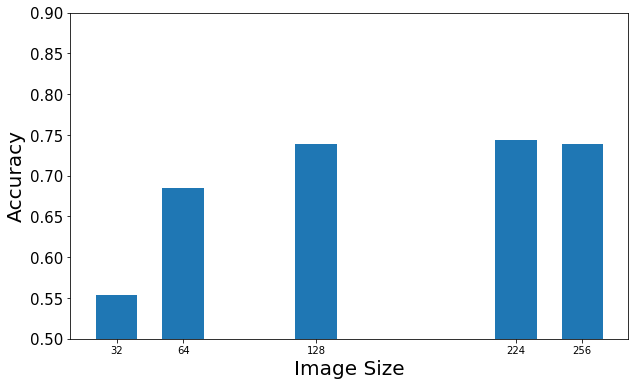

In [27]:
width = 20 # bar width
# Get current size
fig_size = plt.rcParams["figure.figsize"]
# Set new size (0=width,1=height)
fig_size[0] = 10
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size


plt.bar(imagesizes, acc_sz, width, align='center')

plt.tick_params(axis='x', which='major', labelsize=10)
plt.tick_params(axis='y', which='major', labelsize=15)

xrange = np.arange(16, 528, 64)
plt.xticks(imagesizes)
plt.ylim(.5,.9)

plt.xlabel('Image Size', size = 20)
plt.ylabel('Accuracy',size = 20)

plt.show()

# Varying Model Architectures: ResNet, DenseNet, SqueezeNet  etc.

- We try various models for the burn data-set including mobile-device friendly architectures such as SqueezeNet1_1. 

#### Models

In [0]:
tfms = get_transforms(flip_vert=True)
np.random.seed(0)
data2 = ImageDataBunch.from_folder(path, valid_pct=0.3 , ds_tfms=tfms, size=224).normalize(imagenet_stats)

In [0]:


#models
# densenet161 = mod_fa.densenet161 #(pretrained=True)   #make image size less to 16/32, else 'CUDA out of memory'for this extensive model comparison
# inception = models.inception_v3 #(pretrained=True)   #requires sz = 299
# googlenet = models.googlenet(pretrained=True) #inception_v1 #requires sz = 299
# SqueezeNet v1.1 vs. MobileNetV2 vs. Shufflenet   - efficient for mobile devices https://github.com/cedrickchee/data-science-notebooks/tree/master/notebooks/deep_learning/fastai_mobile
# other: Darknet,  WideResNet
# wrn_22 = mod_fa.wrn_22   #TypeError: wrn_22() takes 0 positional arguments but 1 was given
# unet - for segmentation


#10 models
all_models = [resnet18, resnet34, resnet50 , resnet101, resnet152, squeezenet1_1,alexnet, vgg19_bn, densenet161, densenet201] #densenet161, densenet201 'CUDA out of memory', but expect densenet to perform beter than resnet models as in butn1.ipynb
acc_nn = []   #accuracy array for each nn 

for arch in all_models: 

    learn_nn = cnn_learner(data2, arch , metrics=accuracy).mixup().to_fp16()  #ps = 0.5 default, memory limits for densenet if no '.to_fp16()

    #     learn.lr_find()
    #     learn.recorder.plot()

    print('Model', arch)
    %time 
    fit_array = learn_nn.fit_one_cycle(5, 1e-2, pct_start=0.5, callbacks=[SaveModelCallback(learn_nn, every='improvement', monitor='accuracy', name='best')])

    acc_nn.append( accuracy(*learn_nn.get_preds()) )
    
    
learn_nn.save('burn_nosplit_final_nn')

In [15]:
print(all_models)
print(acc_nn)

[<function resnet18 at 0x7f7490505950>, <function resnet34 at 0x7f7490505d90>, <function resnet50 at 0x7f7490505e18>, <function resnet101 at 0x7f7490505ea0>, <function resnet152 at 0x7f7490505f28>, <function squeezenet1_1 at 0x7f7490510950>, <function alexnet at 0x7f7490505620>, <function vgg19_bn at 0x7f7490510620>, <function densenet161 at 0x7f749049dc80>, <function densenet201 at 0x7f749049dbf8>]
[tensor(0.7117), tensor(0.7568), tensor(0.7342), tensor(0.7477), tensor(0.7703), tensor(0.7477), tensor(0.7387), tensor(0.7613), tensor(0.7793), tensor(0.7928)]


#### Plot of Varying Model Architectures Results

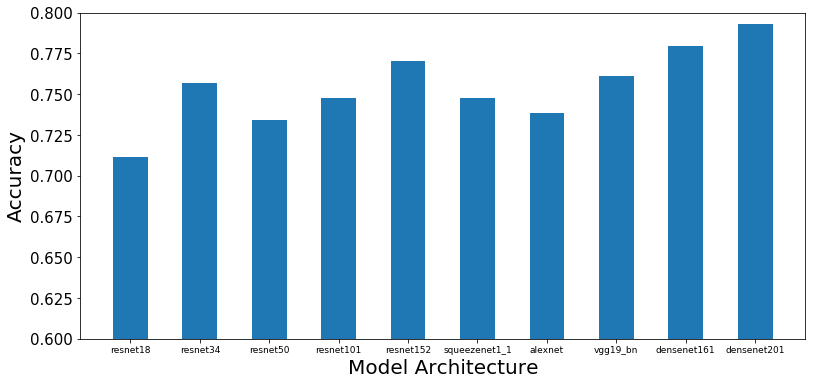

In [18]:
all_models_names = ['resnet18', 'resnet34', 'resnet50' , 'resnet101', 'resnet152', 'squeezenet1_1', 'alexnet', 'vgg19_bn','densenet161', 'densenet201'] 
  
  
width = 0.5 # bar width
# Get current size
fig_size = plt.rcParams["figure.figsize"]
# Set new size (0=width,1=height)
fig_size[0] = 13
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size


plt.bar(all_models_names, acc_nn, width, align='center')

plt.tick_params(axis='x', which='major', labelsize=9)
plt.tick_params(axis='y', which='major', labelsize=15)

# xrange = np.arange(0,1,.1)
plt.xticks(all_models_names )
plt.ylim(.6,.8, .05)

plt.xlabel('Model Architecture', size = 20)
plt.ylabel('Accuracy',size = 20)

plt.show()